# <center>The goal of the script is to build a model that can predict a person's future income. <center>

<b> Importing the necessary libraries <b>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import make_interp_spline
import scipy.stats as st
from collections import Counter
import math
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Task 1

<b> Importing the dataset from the World Income Distribution site which includes income distribution quantiles of each country's population. <b>

In [2]:
df=pd.read_csv(r"C:/Users/Blagoj/\OneDrive\Documents\Openclassrooms\Project 8\data-project-8.csv")

df.head()

,country,year_survey,quantile,nb_quantiles,income,gdpppp
0,ALB,2008,1,100,"728,89795",7297
1,ALB,2008,2,100,"916,66235",7297
2,ALB,2008,3,100,"1010,916",7297
3,ALB,2008,4,100,"1086,9078",7297
4,ALB,2008,5,100,"1132,6997",7297


In [3]:
#Checking for missing values or unexpected dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11599 entries, 0 to 11598
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   country       11599 non-null  object
 1   year_survey   11599 non-null  int64 
 2   quantile      11599 non-null  int64 
 3   nb_quantiles  11599 non-null  int64 
 4   income        11599 non-null  object
 5   gdpppp        11399 non-null  object
dtypes: int64(3), object(3)
memory usage: 543.8+ KB


We can spot 3 potential issues: <br><br>
-200 gdpppp null values. Upon checking, the countries XKX and LAO are missing values in the gdpppp column so we will exclude them from the main dataframe. <br><br>
-Income and gdpppp columns are objects, so we will convert them to int as they should only contain numerical values. <br><br>
-We expect our total amount of lines to be divisible by 100 so it seems like we have some missing quantiles that we need to check

In [4]:
##Filtering Kosovo and Laos out as they are missing gdpppp values.
df = df.dropna(subset=['gdpppp'])

In [5]:
#Removing commas and changing the data types to integer
df['income']=df['income'].str.replace(',', '',regex=True).astype(np.int64)
df['gdpppp']=df['gdpppp'].str.replace(',', '',regex=True).astype(np.int64)

In [6]:
#Which country does not have 100 quantiles:
country_with_missing_value=df['country'].value_counts()[df['country'].value_counts() < 100].index[0]
country_with_missing_value

'LTU'

In [7]:
#Which quantile is missing:
quantile_count=df['quantile'].value_counts()
min_repetitions=quantile_count.min()
quantile_with_least_repetitions = quantile_count[quantile_count==min_repetitions].index[0]
quantile_with_least_repetitions

41

In [8]:
# Calculate the average income for LTU
average_income_ltu = int(df.loc[(df['country'] == country_with_missing_value) & (df['quantile'].isin([quantile_with_least_repetitions-1, quantile_with_least_repetitions+1])), 'income'].mean())

# Create a new DataFrame with the values to append
new_data = {
    'country': ['LTU'],
    'year_survey': [df.loc[df['country'] == country_with_missing_value, 'year_survey'].iloc[0]],
    'quantile': [quantile_with_least_repetitions],
    'nb_quantiles': [df.loc[df['country'] == country_with_missing_value, 'nb_quantiles'].iloc[0]],
    'income': [average_income_ltu],
    'gdpppp': [df.loc[df['country'] == country_with_missing_value, 'gdpppp'].iloc[0]]
}

# Append the new data to the original DataFrame using concat
df = pd.concat([df, pd.DataFrame(new_data)], ignore_index=True, sort=False)

In [9]:
#Checking again to see if we have corrected our dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11400 entries, 0 to 11399
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   country       11400 non-null  object
 1   year_survey   11400 non-null  int64 
 2   quantile      11400 non-null  int64 
 3   nb_quantiles  11400 non-null  int64 
 4   income        11400 non-null  int64 
 5   gdpppp        11400 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 534.5+ KB


In [10]:
#Basic univariate analysis to familiarize ourselves with the given data
df.describe()

,year_survey,quantile,nb_quantiles,income,gdpppp
count,11400.000000,11400.000000,11400.0,1.140000e+04,1.140000e+04
mean,2007.973684,50.500000,100.0,2.259255e+07,4.288360e+07
std,0.912532,28.867336,0.0,2.182970e+07,4.219047e+08
min,2004.000000,1.000000,100.0,8.044000e+03,3.720000e+02
25%,2008.000000,25.750000,100.0,7.462748e+06,3.689000e+03
50%,2008.000000,50.500000,100.0,1.501775e+07,1.110350e+04
75%,2008.000000,75.250000,100.0,3.061078e+07,2.833600e+04
max,2011.000000,100.000000,100.0,1.619977e+08,4.525483e+09


<b> Task 1.1 - Years of data

In [11]:
years_of_data = (df['year_survey'].value_counts() / 100).round().astype(int)
result_table = pd.DataFrame({'Year': years_of_data.index, 'Count': years_of_data.values})

print(result_table)

   Year  Count
0  2008     75
1  2007     15
2  2009     11
3  2010      6
4  2006      5
5  2011      1
6  2004      1


Since not all countries produce annual surveys, we
had to use a “benchmark” year (2008 in this case), that is,
try to get 2008 household surveys for as many countries as
possible, but where there are no surveys conducted in 2008,
to use a year close to 2008. In the event, 101 out of 114
household surveys were conducted in the benchmark year
or one year before or after it, and all but 2 surveys were
done within two years of the benchmark year.

<b> Task 1.2 - Number of countries involved

In [12]:
print("There are", df['country'].nunique(), "number of countries involved, not counting the two we excluded due to missing data")

There are 114 number of countries involved, not counting the two we excluded due to missing data


<b> Task 1.3 - Population covered by the dataset (percentage of world population)

In [13]:
#world bank data extraction. I chose 2008, 2016 and 2022.
pop=pd.read_csv(r"C:\Users\blagoj\OneDrive\Documents\Openclassrooms\Project 8\Population.csv")

non_numeric_values = pop[~pd.to_numeric(pop['2022 [YR2022]'], errors='coerce').notna()]
non_numeric_values

,Series Name,Series Code,Country Name,Country Code,2008 [YR2008],2016 [YR2016],2022 [YR2022]
105,"Population, total",SP.POP.TOTL,IBRD only,IBD,..,..,..
108,"Population, total",SP.POP.TOTL,IDA blend,IDB,..,..,..
109,"Population, total",SP.POP.TOTL,IDA only,IDX,..,..,..
110,"Population, total",SP.POP.TOTL,IDA total,IDA,..,..,..
183,"Population, total",SP.POP.TOTL,Not classified,INX,..,..,..
266,NaN,NaN,NaN,NaN,NaN,NaN,NaN
267,NaN,NaN,NaN,NaN,NaN,NaN,NaN
268,NaN,NaN,NaN,NaN,NaN,NaN,NaN
269,Data from database: Health Nutrition and Popul...,NaN,NaN,NaN,NaN,NaN,NaN
270,Last Updated: 07/05/2023,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
#Getting rid of non-numerical values
pop['2022 [YR2022]'] = pd.to_numeric(pop['2022 [YR2022]'], errors='coerce')
pop = pop.dropna(subset=['2022 [YR2022]'])

In [15]:
#Calculating the percentage of the population covered in our project
pop['2022 [YR2022]']=pop['2022 [YR2022]'].astype(np.int64)

total_pop=pop[pop['Country Name']=="World"]['2022 [YR2022]'].values[0]

merged_pop_df = df.merge(pop, left_on='country', right_on='Country Code', how='inner')


total_used_countries = merged_pop_df['2022 [YR2022]'].sum()

res_pop=total_used_countries/total_pop

print("{:.2%} of the population is covered by this dataset".format(res_pop / 100))

90.30% of the population is covered by this dataset


<b> Task 1.4 The type of quantiles used (quartiles, deciles, ventiles, percentiles, etc.).

In our dataset we have 100 quantiles for each country so we have chosen to proceed with using percentiles throughout the project.

<b> Task 1.5 The $PPP unity and an explanation of why (not why not) it’s a good method to compare countries.

Purchasing power parity (PPP) is a popular macroeconomic analysis metric used to compare economic productivity and standards of living between countries.

PPP involves an economic theory that compares different countries' currencies through a "basket of goods" approach. That is, PPP is the exchange rate at which one nation's currency would be converted into another to purchase the same and same amounts of a large group of products.
PPP is a good method for comparing countries because it provides a more accurate representation of the relative purchasing power and standards of living across different economies, considering the complexities of currency exchange rates and price differences.

To better understand how GDP paired with purchase power parity works, suppose it costs 10 dollars to buy a shirt in the U.S., and it costs 8.00 euros to buy an identical shirt in Germany. To make an apples-to-apples comparison, we must first convert the 8.00 euros into U.S. dollars. If the exchange rate was such that the shirt in Germany costs 15.00 dollars, the PPP would, therefore, be 15/10, or 1.5.

<b> Task 1.6 - A graph showing how diverse countries are in terms of income distribution.

In [16]:
#Calculating the Gini coefficient
def gini_coefficient(data):
    data = np.sort(data)
    index = np.arange(1, data.shape[0] + 1)
    n = data.shape[0]
    return ((2 * np.sum(index * data)) / (n * np.sum(data))) - ((n + 1) / n)

gini_df = df.groupby('country')['income'].apply(gini_coefficient).reset_index()

#Finding the countries with highest and lowest Gini coefficients
country_highest_gini = gini_df.loc[gini_df['income'].idxmax()]
country_lowest_gini = gini_df.loc[gini_df['income'].idxmin()]

print("Country with highest Gini coefficient:", country_highest_gini['country'], country_highest_gini['income'])
print("Country with lowest Gini coefficient:", country_lowest_gini['country'], country_lowest_gini['income'])


Country with highest Gini coefficient: IDN 0.5573072772522452
Country with lowest Gini coefficient: ISL 0.3454934040592106


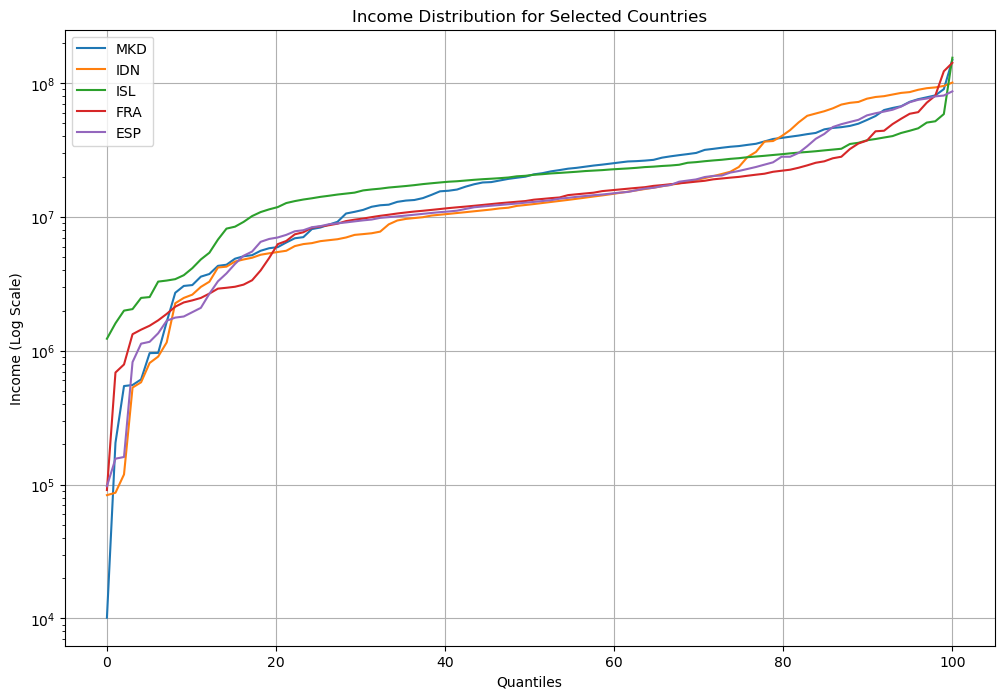

In [17]:
#Among the countries that must be present : your own country, 
#and the two countries that have the greatest and lowest Gini index.
selected_countries = ['MKD', country_highest_gini['country'], country_lowest_gini['country'], 'FRA', 'ESP']

#Filtering dataset to include only selected countries
filtered_df = df[df['country'].isin(selected_countries)]

#Defining the dynamic value for number of quantiles
num_quantiles = 100

#Calculating the actual percentiles from our data's quantiles
quantiles = np.linspace(0, 1, num_quantiles)  # Evenly spaced between 0 and 1
income_quantiles = filtered_df.groupby(['country'])['income'].quantile(quantiles).unstack()

#Plotting
plt.figure(figsize=(12, 8))
sns.set_palette("tab10")

for country in selected_countries:
    x_vals = quantiles * 100  #Converting quantiles to percentages for x-axis
    y_vals = income_quantiles.loc[country].values
    spline = make_interp_spline(x_vals, y_vals, k=3)
    smoothed_vals = spline(x_vals)
    plt.plot(x_vals, smoothed_vals, label=country)

plt.xlabel('Quantiles')
plt.ylabel('Income (Log Scale)')
plt.yscale('log')  # Logarithmic scale for income
plt.title('Income Distribution for Selected Countries')
plt.legend()
plt.grid(True)
plt.show()

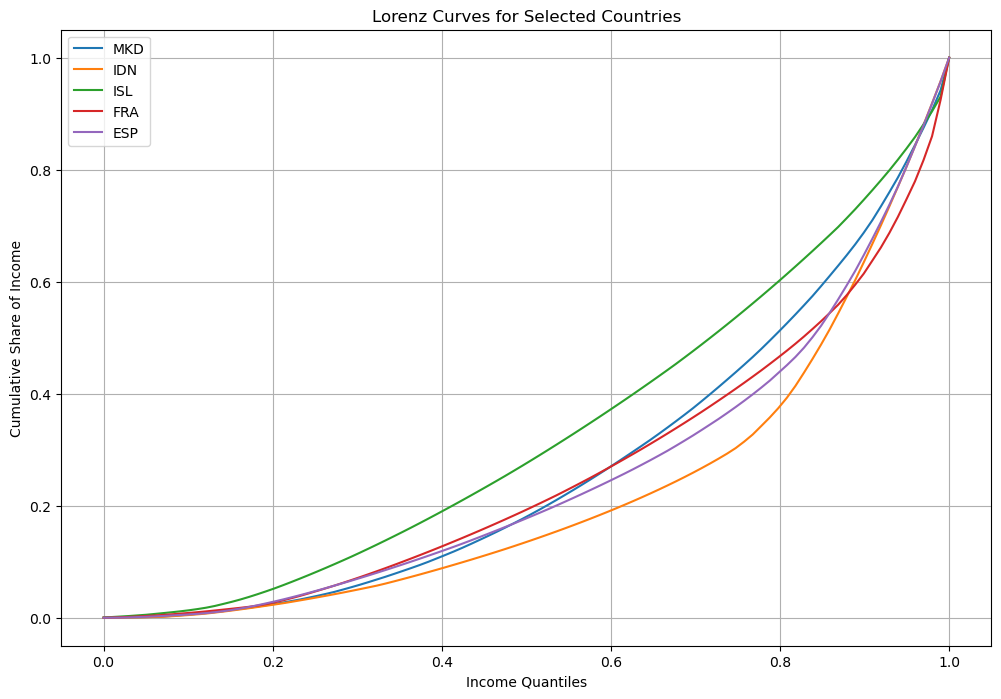

In [18]:
#Plotting Lorenz Curve
plt.figure(figsize=(12, 8))

for country in selected_countries:
    country_df = filtered_df[filtered_df['country'] == country]
    sorted_incomes = country_df['income'].sort_values()
    cumulative_share = np.cumsum(sorted_incomes) / np.sum(sorted_incomes)
    plt.plot(np.linspace(0, 1, len(cumulative_share)), cumulative_share, label=f'{country}')
    
plt.xlabel('Income Quantiles')
plt.ylabel('Cumulative Share of Income')
plt.title('Lorenz Curves for Selected Countries')
plt.legend()
plt.grid(True)
plt.show()

# Task 2

<b> Task 2.1 Calculate the average income of each country <b>

In [19]:
#Calculating the average income of each country
avg_inc_df=df.groupby('country')['income'].mean().reset_index()
avg_inc_df

,country,income
0,ALB,19931742.00
1,ARG,23585592.08
2,ARM,19720633.27
3,AUT,20639601.89
4,AZE,20882927.44
...,...,...
109,USA,18948040.17
110,VEN,25939648.85
111,VNM,25688318.76
112,YEM,25033178.77


In [20]:
#Adding the avg income to the main dataframe
final_df=pd.merge(df, avg_inc_df, on='country')
final_df

,country,year_survey,quantile,nb_quantiles,income_x,gdpppp,income_y
0,ALB,2008,1,100,72889795,7297,19931742.00
1,ALB,2008,2,100,91666235,7297,19931742.00
2,ALB,2008,3,100,1010916,7297,19931742.00
3,ALB,2008,4,100,10869078,7297,19931742.00
4,ALB,2008,5,100,11326997,7297,19931742.00
...,...,...,...,...,...,...,...
11395,COD,2008,96,100,8106233,30319305,18416009.61
11396,COD,2008,97,100,9117834,30319305,18416009.61
11397,COD,2008,98,100,10578074,30319305,18416009.61
11398,COD,2008,99,100,12866029,30319305,18416009.61


<b> Task 2.2 - Adding gini coefficients for each country <b>

In [21]:
#Adding the gini values to the main dataframe
all_df=pd.merge(final_df, gini_df, on='country')
all_df

,country,year_survey,quantile,nb_quantiles,income_x,gdpppp,income_y,income
0,ALB,2008,1,100,72889795,7297,19931742.00,0.431383
1,ALB,2008,2,100,91666235,7297,19931742.00,0.431383
2,ALB,2008,3,100,1010916,7297,19931742.00,0.431383
3,ALB,2008,4,100,10869078,7297,19931742.00,0.431383
4,ALB,2008,5,100,11326997,7297,19931742.00,0.431383
...,...,...,...,...,...,...,...,...
11395,COD,2008,96,100,8106233,30319305,18416009.61,0.450293
11396,COD,2008,97,100,9117834,30319305,18416009.61,0.450293
11397,COD,2008,98,100,10578074,30319305,18416009.61,0.450293
11398,COD,2008,99,100,12866029,30319305,18416009.61,0.450293


In [22]:
#Renaming column names
all_df=all_df.rename(columns={'quantile': 'class_child', 'income_y': 'avg_income', 'income': 'gini_coef'})
all_df

,country,year_survey,class_child,nb_quantiles,income_x,gdpppp,avg_income,gini_coef
0,ALB,2008,1,100,72889795,7297,19931742.00,0.431383
1,ALB,2008,2,100,91666235,7297,19931742.00,0.431383
2,ALB,2008,3,100,1010916,7297,19931742.00,0.431383
3,ALB,2008,4,100,10869078,7297,19931742.00,0.431383
4,ALB,2008,5,100,11326997,7297,19931742.00,0.431383
...,...,...,...,...,...,...,...,...
11395,COD,2008,96,100,8106233,30319305,18416009.61,0.450293
11396,COD,2008,97,100,9117834,30319305,18416009.61,0.450293
11397,COD,2008,98,100,10578074,30319305,18416009.61,0.450293
11398,COD,2008,99,100,12866029,30319305,18416009.61,0.450293


<b> Task 2.3 - Adding elasticity coefficients for each country <b>

In [23]:
#Adding elasticity coefficient
df=pd.read_csv(r"C:/Users/Blagoj/\OneDrive\Documents\Openclassrooms\Project 8\Elascity coefficient world bank.csv")

df_sorted=df.sort_values(by=['iso3', 'cohort'], ascending=[True, False])

#Define a function to check if all values in 'IGEincome' column are NaN
def has_all_nan(series):
    return series.isnull().all()

#Group by 'iso3' and filter to keep only groups that have all NaN values in 'IGEincome'
countries_with_no_numerical_ige = df_sorted.groupby('iso3')['IGEincome'].filter(has_all_nan)

#Filter rows where 'iso3' is not in the countries with all NaN 'IGEincome' values
df_countries_with_numerical_ige = df_sorted[~df_sorted['iso3'].isin(countries_with_no_numerical_ige)]

#Keep the top line with numerical 'IGEincome' for countries that have it
df_countries_with_numerical_ige = df_countries_with_numerical_ige.groupby('iso3').first().reset_index()

#Filter rows where 'iso3' is in the countries with all NaN 'IGEincome' values
df_countries_without_numerical_ige = df_sorted[df_sorted['iso3'].isin(countries_with_no_numerical_ige)]

#Keep the top line with NaN 'IGEincome' for countries without numerical 'IGEincome'
df_countries_without_numerical_ige = df_countries_without_numerical_ige.groupby('iso3').first().reset_index()

#Concatenate the filtered DataFrames
elas_df = pd.concat([df_countries_with_numerical_ige, df_countries_without_numerical_ige], ignore_index=True)

In [24]:
all_df=all_df.merge(elas_df[['iso3','IGEincome']], left_on='country', right_on='iso3', how='left')
all_df

,country,year_survey,class_child,nb_quantiles,income_x,gdpppp,avg_income,gini_coef,iso3,IGEincome
0,ALB,2008,1,100,72889795,7297,19931742.00,0.431383,ALB,0.815874
1,ALB,2008,2,100,91666235,7297,19931742.00,0.431383,ALB,0.815874
2,ALB,2008,3,100,1010916,7297,19931742.00,0.431383,ALB,0.815874
3,ALB,2008,4,100,10869078,7297,19931742.00,0.431383,ALB,0.815874
4,ALB,2008,5,100,11326997,7297,19931742.00,0.431383,ALB,0.815874
...,...,...,...,...,...,...,...,...,...,...
11395,COD,2008,96,100,8106233,30319305,18416009.61,0.450293,COD,0.707703
11396,COD,2008,97,100,9117834,30319305,18416009.61,0.450293,COD,0.707703
11397,COD,2008,98,100,10578074,30319305,18416009.61,0.450293,COD,0.707703
11398,COD,2008,99,100,12866029,30319305,18416009.61,0.450293,COD,0.707703


In [25]:
#Extracting the countries with missing elasticity values from our dataframe
missing_IGEincome_countries = all_df[pd.isna(all_df['IGEincome'])]
missing_IGEincome_countries.to_csv(r"C:\Users\Blagoj\OneDrive\Documents\Openclassrooms\Project 8\noIGE.csv")

In [26]:
#Importing back a file containing the values that I've manually added for the missing countries
missing_ige_df=pd.read_csv(r"C:\Users\Blagoj\OneDrive\Documents\Openclassrooms\Project 8\missing_ige.csv")
missing_ige_df

,Code,Name,Region,PJ
0,ARG,Argentina,Latin America/Africa,0.66
1,ARM,Armenia,Asia,0.50
2,AZE,Azerbaijan,Asia,0.50
3,BFA,Burkina Faso,Latin America/Africa,0.66
4,BGR,Bulgaria,Europe (except nordic countries),0.40
5,BTN,Bhutan,Asia,0.50
6,CAF,Central African Republic,Latin America/Africa,0.66
7,CIV,Cote d'Ivoire,Latin America/Africa,0.66
8,CMR,Cameroon,Latin America/Africa,0.66
9,CRI,Costa Rica,Australia/New Zealand/USA,0.40


In [27]:
#Adding the missing values to the main dataframe
all_df = all_df.merge(missing_ige_df[['Code', 'PJ']], left_on='country', right_on='Code', how='left')

all_df['IGEincome'].fillna(all_df['PJ'], inplace=True)

all_df.drop(columns=['Code', 'PJ'], inplace=True)

all_df

,country,year_survey,class_child,nb_quantiles,income_x,gdpppp,avg_income,gini_coef,iso3,IGEincome
0,ALB,2008,1,100,72889795,7297,19931742.00,0.431383,ALB,0.815874
1,ALB,2008,2,100,91666235,7297,19931742.00,0.431383,ALB,0.815874
2,ALB,2008,3,100,1010916,7297,19931742.00,0.431383,ALB,0.815874
3,ALB,2008,4,100,10869078,7297,19931742.00,0.431383,ALB,0.815874
4,ALB,2008,5,100,11326997,7297,19931742.00,0.431383,ALB,0.815874
...,...,...,...,...,...,...,...,...,...,...
11395,COD,2008,96,100,8106233,30319305,18416009.61,0.450293,COD,0.707703
11396,COD,2008,97,100,9117834,30319305,18416009.61,0.450293,COD,0.707703
11397,COD,2008,98,100,10578074,30319305,18416009.61,0.450293,COD,0.707703
11398,COD,2008,99,100,12866029,30319305,18416009.61,0.450293,COD,0.707703


In [28]:
#Storing the elasticity coefs in a separate dataframe, will be needed later on.
pj_values=all_df.groupby('country')['IGEincome'].agg('first').reset_index()

<b> Task 2.4 Generating parent class <b>

We have a few predefined functions below that help us calculate the parent's class:

In [29]:
#This function generates child and parent incomes
def generate_incomes(n, pj):
    ln_y_parent = st.norm(0,1).rvs(size=n)
    residues = st.norm(0,1).rvs(size=n)
    return np.exp(pj*ln_y_parent + residues), np.exp(ln_y_parent)

In [30]:
#This function is used in the compute_quantiles below
def quantiles(l, nb_quantiles):
    size = len(l)
    l_sorted = l.copy()
    l_sorted = l_sorted.sort_values()
    quantiles = np.round(np.arange(1, nb_quantiles+1, nb_quantiles/size)-0.5+1./size)
    q_dict = {a:int(b) for a,b in zip(l_sorted,quantiles)}
    return pd.Series([q_dict[e] for e in l])

#This function returns a "sample" dataframe based on the values generated with the generate_income function
def compute_quantiles(y_child, y_parents, nb_quantiles):
    y_child = pd.Series(y_child)
    y_parents = pd.Series(y_parents)
    c_i_child = quantiles(y_child, nb_quantiles)
    c_i_parent = quantiles(y_parents, nb_quantiles)
    sample = pd.concat([y_child, y_parents, c_i_child, c_i_parent], axis=1)
    sample.columns = ["y_child", "y_parents", "c_i_child","c_i_parent"]
    return sample

In [31]:
#This function is used in the conditional_distributions below
def distribution(counts, nb_quantiles):
    distrib = []
    total = counts["counts"].sum()
    if total == 0 :
        return [0] * nb_quantiles
    for q_p in range(1, nb_quantiles+1):
        subset = counts[counts.c_i_parent == q_p]
        if len(subset):
            nb = subset["counts"].values[0]
            distrib += [nb / total]
        else:
            distrib += [0]
    return distrib

#Function for estimating the probabilities
def conditional_distributions(sample, nb_quantiles):
    counts = sample.groupby(["c_i_child","c_i_parent"]).apply(len)
    counts = counts.reset_index()
    counts.columns = ["c_i_child","c_i_parent","counts"]
    mat = []
    for child_quantile in np.arange(nb_quantiles)+1:
        subset = counts[counts.c_i_child == child_quantile]
        mat += [distribution(subset, nb_quantiles)]
    return np.array(mat)

In [32]:
#Function for ploting the CDs so we can see if the values are distributed as we are expecting them
def plot_conditional_distributions(p, cd, nb_quantiles):
    plt.figure()
    cumul = np.array([0] * nb_quantiles)
    for i, child_quantile in enumerate(cd):
        plt.bar(np.arange(nb_quantiles)+1, child_quantile, bottom=cumul, width=0.95, label = str(i+1) +"e")
        cumul = cumul + np.array(child_quantile)
    plt.axis([.5, nb_quantiles*1.3 ,0 ,1])
    plt.title("p=" + str(p))
    plt.legend()
    plt.xlabel("c_i_parent")
    plt.ylabel("probability of having c_i_child")
    plt.show()

In [33]:
#Function for testing, can calculate single probability with given values.
def proba_cond(c_i_parent, c_i_child, mat):
    return mat[c_i_child, c_i_parent]

Example with fixed values where the pj is high (low mobility):

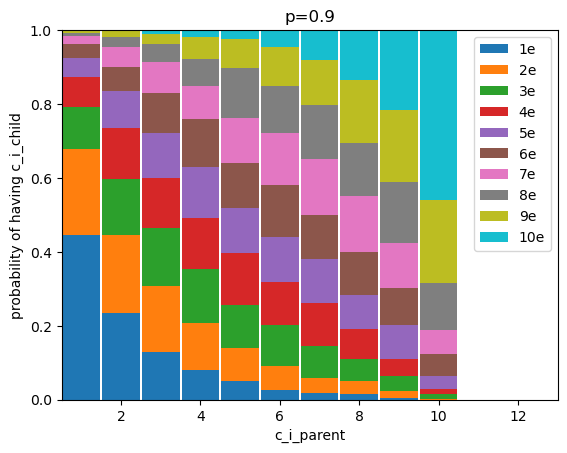

In [34]:
nb_quantiles = 10 #We are using this value just so we can plot faster. Will change it back to 100 later.

n = 1000 * nb_quantiles

pj=0.9

y_child, y_parents = generate_incomes(n, pj)

sample = compute_quantiles(y_child, y_parents, nb_quantiles)
cd = conditional_distributions(sample, nb_quantiles)
plot_conditional_distributions(pj, cd, nb_quantiles) # very slow except if nb_quantiles < 11

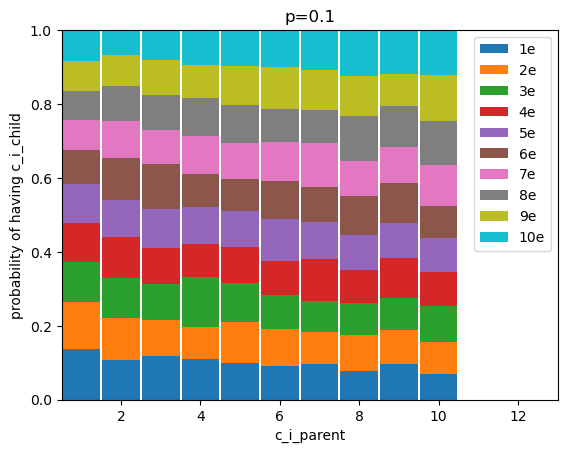

In [35]:
#Example with low pj (high mobility):
pj=0.1
y_child, y_parents = generate_incomes(n, pj)

sample = compute_quantiles(y_child, y_parents, nb_quantiles)
cd = conditional_distributions(sample, nb_quantiles)
plot_conditional_distributions(pj, cd, nb_quantiles) # very slow except if nb_quantiles < 11

Example of proba_cond:

In [36]:
c_i_child = 8
c_i_parent = 5
p = proba_cond(c_i_parent, c_i_child, cd)
print("\nP(c_i_parent = {} | c_i_child = {}, pj = {}) = {}".format(c_i_parent, c_i_child, pj, p))


P(c_i_parent = 5 | c_i_child = 8, pj = 0.1) = 0.114


Now that we have our conditional distributions, we can proceed with the next steps. <br>
we need to add clones, for each child income class and for each country we need to generate 499 clones:

In [37]:
#Function for adding cloned lines:
def create_cloned_lines(df, num_clones):
    cloned_df = df.loc[df.index.repeat(num_clones)].reset_index(drop=True)
    return cloned_df

In [38]:
# Clone each line in 'all_df' dataframe 499 times
num_clones=500
cloned_df = create_cloned_lines(all_df, num_clones)
cloned_df

,country,year_survey,class_child,nb_quantiles,income_x,gdpppp,avg_income,gini_coef,iso3,IGEincome
0,ALB,2008,1,100,72889795,7297,19931742.00,0.431383,ALB,0.815874
1,ALB,2008,1,100,72889795,7297,19931742.00,0.431383,ALB,0.815874
2,ALB,2008,1,100,72889795,7297,19931742.00,0.431383,ALB,0.815874
3,ALB,2008,1,100,72889795,7297,19931742.00,0.431383,ALB,0.815874
4,ALB,2008,1,100,72889795,7297,19931742.00,0.431383,ALB,0.815874
...,...,...,...,...,...,...,...,...,...,...
5699995,COD,2008,100,100,22431226,30319305,18416009.61,0.450293,COD,0.707703
5699996,COD,2008,100,100,22431226,30319305,18416009.61,0.450293,COD,0.707703
5699997,COD,2008,100,100,22431226,30319305,18416009.61,0.450293,COD,0.707703
5699998,COD,2008,100,100,22431226,30319305,18416009.61,0.450293,COD,0.707703


In [39]:
#Function for making sure that we add 500 values for each cd row.
#We use this one in the next function called populate_parent_class.
def round_values(original_values, target_sum):
    multiplied_values = [value * target_sum for value in original_values]
    rounded_values = [math.floor(value) for value in multiplied_values]
    sum_difference = target_sum - sum(rounded_values)

    #Creating a list of indices sorted by descending order of multiplied values
    sorted_indices = sorted(range(len(multiplied_values)), key=lambda i: -multiplied_values[i])

    #Distributing the difference among the rounded values, prioritizing largest values
    for i in range(abs(sum_difference)):
        index = sorted_indices[i % len(sorted_indices)]

        if sum_difference > 0:
            # Increment one of the values by 1
            rounded_values[index] += 1
        elif sum_difference < 0:
            # Decrement one of the values by 1
            rounded_values[index] -= 1

    #Making sure the sum is exactly the target sum
    assert sum(rounded_values) == target_sum

    return rounded_values

In [40]:
#This function will calculate and fill the parent class for each individual.
def populate_parent_class(df, cd):
    parent_class_values = []
    repetitions = 500

    for j in range(100):
        current_class_value=0
        temp_values = []
        for row in cd:
            temp_values.append(row[j])           
        to_target_sum=round_values(temp_values, repetitions)

        for i in range(100):
            current_class_value+=1
            num_times = to_target_sum[i]
            country_parent_class = [current_class_value + 1] * num_times
            #Add the corresponding parent_class values to the list
            for k in range (num_times):
                parent_class_values.append(current_class_value)

    # Add the parent_class column to the DataFrame
    df['parent_class'] = parent_class_values

In [41]:
#Calling the function that populates the parent class for each country:
#!!!This code executes for up to 4 minutes!!!
nb_quantiles=100

parent_class_values = []

for country in cloned_df['country'].unique():
    pj = pj_values.loc[pj_values['country'] == country, 'IGEincome'].values[0]
    y_child, y_parents = generate_incomes(n, pj)
    sample = compute_quantiles(y_child, y_parents, nb_quantiles)
    cd = conditional_distributions(sample, nb_quantiles)

    current_country_df = cloned_df.loc[cloned_df['country'] == country].copy()

    populate_parent_class(current_country_df, cd)

    cloned_df.loc[cloned_df['country'] == country, 'parent_class'] = current_country_df['parent_class'].values
    
cloned_df['parent_class'] = cloned_df['parent_class'].astype(int)

In [42]:
#Checking if we have values for parent_class
cloned_df

,country,year_survey,class_child,nb_quantiles,income_x,gdpppp,avg_income,gini_coef,iso3,IGEincome,parent_class
0,ALB,2008,1,100,72889795,7297,19931742.00,0.431383,ALB,0.815874,1
1,ALB,2008,1,100,72889795,7297,19931742.00,0.431383,ALB,0.815874,1
2,ALB,2008,1,100,72889795,7297,19931742.00,0.431383,ALB,0.815874,1
3,ALB,2008,1,100,72889795,7297,19931742.00,0.431383,ALB,0.815874,1
4,ALB,2008,1,100,72889795,7297,19931742.00,0.431383,ALB,0.815874,1
...,...,...,...,...,...,...,...,...,...,...,...
5699995,COD,2008,100,100,22431226,30319305,18416009.61,0.450293,COD,0.707703,100
5699996,COD,2008,100,100,22431226,30319305,18416009.61,0.450293,COD,0.707703,100
5699997,COD,2008,100,100,22431226,30319305,18416009.61,0.450293,COD,0.707703,100
5699998,COD,2008,100,100,22431226,30319305,18416009.61,0.450293,COD,0.707703,100


# Task 3

<b> Task 3.1 - Perform an ANOVA with the individual's country as the only explanatory variable <b>

In [43]:
grouped_data = cloned_df.groupby('country')

f_statistic, p_value = st.f_oneway(*[group['income_x'] for name, group in grouped_data])

alpha = 0.05
print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")

if p_value < alpha:
    print("Reject the null hypothesis: There are significant differences in child income among countries.")
else:
    print("Fail to reject the null hypothesis: There are no significant differences in child income among countries.")

F-statistic: 1101.0928857565436
P-value: 0.0
Reject the null hypothesis: There are significant differences in child income among countries.


<b> Task 3.2 - A linear regression including as explanatory variables only the mean income and the Gini index of the individual 's country. <b>

In [44]:
#First version
model='income_x~avg_income+gini_coef'
result=smf.ols(model, data=cloned_df).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               income_x   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                 6.221e+04
Date:                Wed, 27 Sep 2023   Prob (F-statistic):               0.00
Time:                        08:20:03   Log-Likelihood:            -1.0435e+08
No. Observations:             5700000   AIC:                         2.087e+08
Df Residuals:                 5699997   BIC:                         2.087e+08
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2.623e-05   1.15e+05  -2.27e-10      1.000   -2.26e+05    2.26e+05
avg_income     1.0000      0.003    323.995      0.000       0.994       1.006
gini_coef      0.0001   2.59e+05   3.97e-10      1.000   -5.08e+05    5.08e+05
==============================================================================
Omnibus:                  1673943.120   Durbin-Watson:                   0.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4423983.078
Skew:                           1.599   Prob(JB):                         0.00
Kurtosis:                       5.898   Cond. No.                     6.99e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.99e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [45]:
#Second version with logarithmic transformation of mean income and the child income
model2 = sm.OLS.from_formula('np.log(income_x) ~ np.log(avg_income) + gini_coef', data=cloned_df)
results2 = model2.fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       np.log(income_x)   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                 3.179e+04
Date:                Wed, 27 Sep 2023   Prob (F-statistic):               0.00
Time:                        08:20:05   Log-Likelihood:            -9.0726e+06
No. Observations:             5700000   AIC:                         1.815e+07
Df Residuals:                 5699997   BIC:                         1.815e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.2250      0.062     19.866      0.000       1.104       1.346
np.log(avg_income)     0.9492      0.004    250.453      0.000       0.942       0.957
gini_coef             -1.8529      0.014   -129.029      0.000      -1.881      -1.825
==============================================================================
Omnibus:                  1073304.567   Durbin-Watson:                   0.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2415576.227
Skew:                          -1.086   Prob(JB):                         0.00
Kurtosis:                       5.335   Cond. No.                     2.11e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.11e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<b> Task 3.3 - A linear regression including as explanatory variables the mean income, the Gini index of the individual 's country and the parent’s income class. <b>

In [46]:
#First version
model3 = sm.OLS.from_formula('income_x ~ avg_income + gini_coef + parent_class', data=cloned_df)
results3 = model3.fit()
print(results3.summary())

                            OLS Regression Results                            
Dep. Variable:               income_x   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                 4.176e+04
Date:                Wed, 27 Sep 2023   Prob (F-statistic):               0.00
Time:                        08:20:08   Log-Likelihood:            -1.0435e+08
No. Observations:             5700000   AIC:                         2.087e+08
Df Residuals:                 5699996   BIC:                         2.087e+08
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     4.579e+05   1.16e+05      3.932   

In [47]:
#Second version with logarithmic transformation of mean income and the child income
model4 = sm.OLS.from_formula('np.log(income_x) ~ np.log(avg_income) + gini_coef + parent_class', data=cloned_df)
results4 = model4.fit()
results4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       np.log(income_x)   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                 2.121e+04
Date:                Wed, 27 Sep 2023   Prob (F-statistic):               0.00
Time:                        08:20:10   Log-Likelihood:            -9.0726e+06
No. Observations:             5700000   AIC:                         1.815e+07
Df Residuals:                 5699996   BIC:                         1.815e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.2310      0.062     19.961      0.000       1.110       1.352
np.log(avg_income)     0.9492      0.004    250.454      0.000       0.942       0.957
gini_coef             -1.8529      0.014   -129.030      0.000      -1.881      -1.825
parent_class          -0.0001   1.72e-05     -6.878      0.000      -0.000   -8.48e-05
==============================================================================
Omnibus:                  1073554.037   Durbin-Watson:                   0.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2416403.811
Skew:                          -1.086   Prob(JB):                         0.00
Kurtosis:                       5.336   Cond. No.                     7.47e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.47e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<b> It appears that our third model yields the most promising results. The substantial F-statistic suggests that our model as a whole is statistically significant. However, the adjusted R-squared value is quite low, indicating that only approximately 2.2% of the variability in income_x can be accounted for by the factors included in the model. <br> <br>
In summary, while it does seem that both average income and parent class have some influence on a child's income (income_x), they don't explain a significant portion of the income variation. The gini_coef variable does not appear to be a significant factor. <br> <br> 
Therefore, based on these results, we cannot confidently affirm the findings from the study, which suggested that 60% of the total variance in income_x can be explained by the country's characteristics (mean income and Gini index), nor can we confirm that 80% of the total variance is explained solely by the country and parents' income, as the study had indicated. <b>